## Временные ряды. Кейс 1. EDA по Hourly Energy Consumption и Brent

Содержание:
* [Определение временного ряда](#tl)
* [Обзор данных о потреблении энергии в одном из районов Восточной Электросети США (DUQ_hourly.csv)](#eda)
* [Проверка качества и порядка разметки выборки с информацией о потреблении энергии в одном из районов Восточной Электросети США (DUQ_hourly.csv), описание особенностей выборки](#razm)
* [Ресемплинг данных (База Brent)](#res)
* [График изменения среднего по выборке и среднего отклонения по выборке на недельных, месячных и годовых группах для Brent](#bgraph)

In [291]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error

%matplotlib inline

### <left>Определение временного ряда<a class="anchor" id="tl"></a><left>

а) зависимость цены на недвижимость в конкретном регионе от времени имеет зависимость от внешних факторов, в частности от особенностей региона. В ряде случаев можно выявить закономерности, сезонность и работать с данными, как с временным рядом.

б) скорость полета самолета при перелете из аэропорта А в аэропорт В можно интерпретировать, как временной ряд. Скорость взаимосвязана с временным параметром, в рамках одного перелета по данным можно сделать выводы о состоянии полета, взлете и посадке. В рамках нескольких циклов можно составить паттерн строить прогнозы.

в) количество отказов компьютера можно рассматривать, как вероятностное событие, а данные не имеют связи между собой, что не позволяет интерпретировать такой датасет, как временной ряд.

Однако, при рассмотрении отказов компьютеров в пределах организации, можно выявить закономерность по минимизации отказов в праздничные дни, а также увеличений числа отказов в дни после праздников и выходных (человеческий факторв), а также в дни высокой загрузки оборудования на предприятии.

г) число обращений в поликлинику по району можно рассматривать, как временной ряд. Заболевания имеют сезонные пики активности. На основе этих данных можно прогнозировать нагрузку на поликлиннику.

д) координаты автобуса при движении по маршруту имеют взаимосвязь с временоой характеристикой и могут рассматриваться, как временной ряд. В циклическом случае движения по одному маршруту модель на основе временного ряда позволит составить паттерн движения, предсказать по нему положение автобуса в определенный момент времени или выявить отклонение от маршрута.

е) координаты фигуры нарушителя в файле видеофиксации охранной системы. Для координат передвижения временная характеристика является значимой. В частном случае, такие данные можно рассматривать как временной ряд для выявления паттерна поведения нарушителя среди паттернов поведения законопослушных граждан.

### <left>Обзор данных о потреблении энергии в одном из районов Восточной Электросети США (DUQ_hourly.csv)<a class="anchor" id="eda"></a><left>

In [292]:
df = pd.read_csv("DUQ_hourly.csv", sep=',', index_col=[0], parse_dates=[0])

In [293]:
df.head()

,DUQ_MW
Datetime,
2005-12-31 01:00:00,1458.0
2005-12-31 02:00:00,1377.0
2005-12-31 03:00:00,1351.0
2005-12-31 04:00:00,1336.0
2005-12-31 05:00:00,1356.0


In [294]:
# Пропуски в ряде отсутствуют
df['DUQ_MW'].isnull().sum()

0

In [295]:
# Оценка аномальных выбросов
df['DUQ_MW'].quantile(.99)

2587.0

In [296]:
df['DUQ_MW'].max()

3054.0

In [297]:
df.loc[df["DUQ_MW"] == df["DUQ_MW"].max()]

,DUQ_MW
Datetime,
2012-06-29 14:00:00,3054.0


Визуализация данных

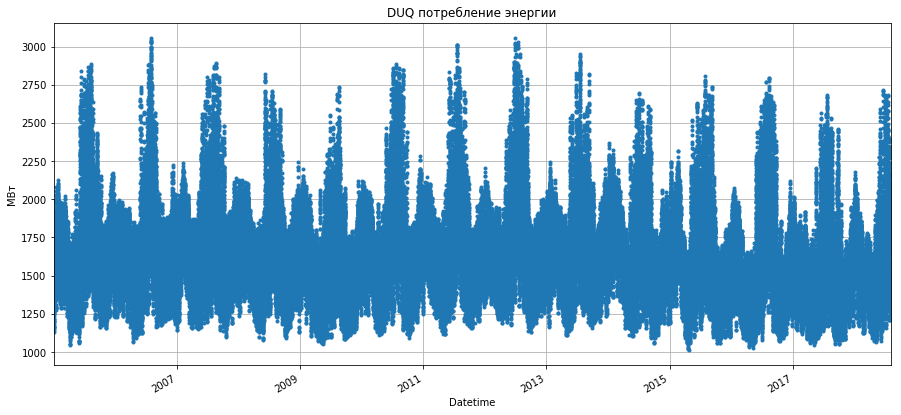

In [298]:
# Аномальные выбросы не замечены

df['DUQ_MW'].plot(style = '.', figsize = ( 15, 7 ), title = 'DUQ потребление энергии')
plt.ylabel('МВт')
plt.grid()
plt.show()

Изменение потребления энергии в течение года

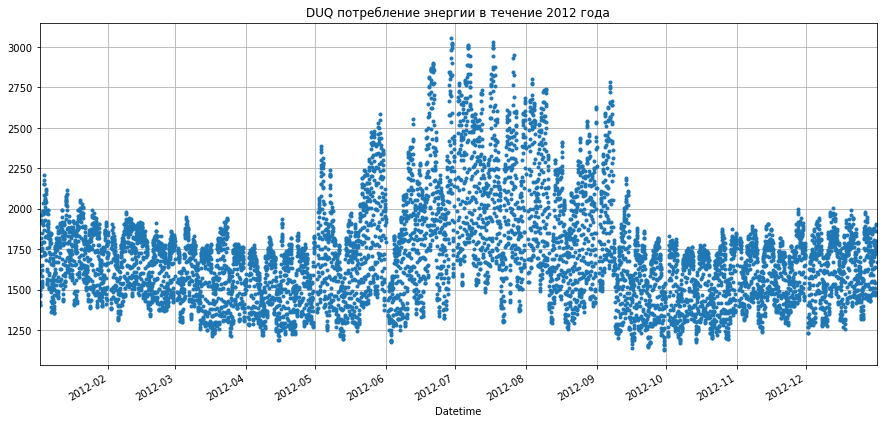

In [299]:
df['date'] = df.index
data_2012 = df.loc[np.logical_and(
        np.logical_and(
        df['date'].dt.year == 2012,
        df['date'].dt.month > 0),
        df['date'].dt.day > 1)]

data_2012['DUQ_MW'].plot( style='.', figsize=( 15, 7 ), title='DUQ потребление энергии в течение 2012 года' )
plt.grid()
plt.show()

Изменение потребления энергии в течение месяца

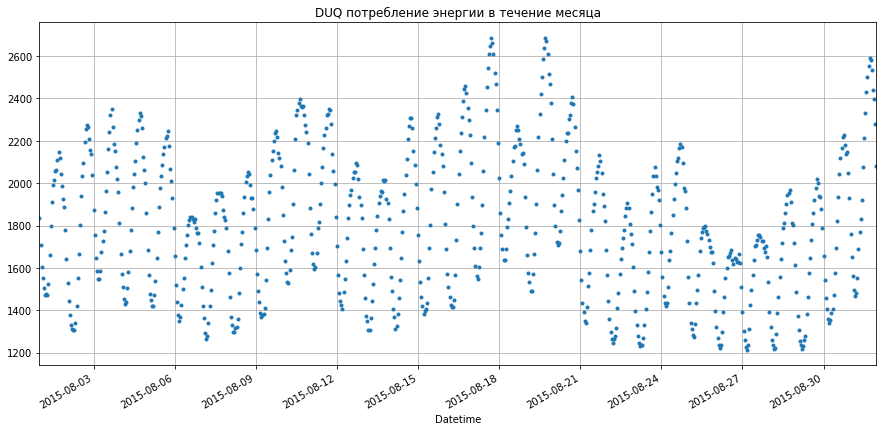

In [300]:
df['date'] = df.index
data_one_day = df.loc[np.logical_and(
        np.logical_and(
        df['date'].dt.year == 2015,
        df['date'].dt.month == 8),
        df['date'].dt.day > 0)]

data_one_day['DUQ_MW'].plot( style='.', figsize=( 15, 7 ), title='DUQ потребление энергии в течение месяца' )
plt.grid()
plt.show()

### <left>Проверка качества и порядка разметки выборки с информацией о потреблении энергии в одном из районов Восточной Электросети США (DUQ_hourly.csv), описание особенностей выборки<a class="anchor" id="razm"></a><left>

#### Поиск дубляжей

Обнаружено 4 дубля временных меток. Все дубли созданы в ноябре начиная с 2014 года. Цикличность события указывает на изменение настройки часов в системе сбора данных

In [301]:
count_data = df['date'].value_counts()
count_data.sort_values(ascending=False).head()

2017-11-05 02:00:00    2
2014-11-02 02:00:00    2
2015-11-01 02:00:00    2
2016-11-06 02:00:00    2
2007-09-13 23:00:00    1
Name: date, dtype: int64

In [302]:
df.loc[count_data.iloc[:4].index]

,DUQ_MW,date
Datetime,,
2017-11-05 02:00:00,1131.0,2017-11-05 02:00:00
2017-11-05 02:00:00,1105.0,2017-11-05 02:00:00
2014-11-02 02:00:00,1272.0,2014-11-02 02:00:00
2014-11-02 02:00:00,1240.0,2014-11-02 02:00:00
2015-11-01 02:00:00,1113.0,2015-11-01 02:00:00
2015-11-01 02:00:00,1138.0,2015-11-01 02:00:00
2016-11-06 02:00:00,1121.0,2016-11-06 02:00:00
2016-11-06 02:00:00,1107.0,2016-11-06 02:00:00


#### Поиск пропусков в данных

In [303]:
data_time_D = pd.date_range('31/12/2005', '02/01/2018', freq="H")
data_time_D

DatetimeIndex(['2005-12-31 00:00:00', '2005-12-31 01:00:00',
               '2005-12-31 02:00:00', '2005-12-31 03:00:00',
               '2005-12-31 04:00:00', '2005-12-31 05:00:00',
               '2005-12-31 06:00:00', '2005-12-31 07:00:00',
               '2005-12-31 08:00:00', '2005-12-31 09:00:00',
               ...
               '2018-01-31 15:00:00', '2018-01-31 16:00:00',
               '2018-01-31 17:00:00', '2018-01-31 18:00:00',
               '2018-01-31 19:00:00', '2018-01-31 20:00:00',
               '2018-01-31 21:00:00', '2018-01-31 22:00:00',
               '2018-01-31 23:00:00', '2018-02-01 00:00:00'],
              dtype='datetime64[ns]', length=105961, freq='H')

In [304]:
missed_data = []
for hour in data_time_D:
    if hour not in df['date']:
        print(hour)
        missed_data.append(hour)
print(f'Обнаружен {len(missed_data)} пропуск')

2006-04-02 03:00:00
2006-10-29 02:00:00
2007-03-11 03:00:00
2007-11-04 02:00:00
2008-03-09 03:00:00
2008-11-02 02:00:00
2009-03-08 03:00:00
2009-11-01 02:00:00
2010-03-14 03:00:00
2010-11-07 02:00:00
2010-12-10 00:00:00
2011-03-13 03:00:00
2011-11-06 02:00:00
2012-03-11 03:00:00
2012-11-04 02:00:00
2013-03-10 03:00:00
2013-11-03 02:00:00
2014-03-09 03:00:00
2015-03-08 03:00:00
2016-03-13 03:00:00
2017-03-12 03:00:00
Обнаружен 21 пропуск


##### Визуализация одного из пропусков

In [305]:
df['2015-03-08 01:00:00':'2015-03-08 06:00:00'].index

DatetimeIndex(['2015-03-08 01:00:00', '2015-03-08 02:00:00',
               '2015-03-08 04:00:00', '2015-03-08 05:00:00',
               '2015-03-08 06:00:00'],
              dtype='datetime64[ns]', name='Datetime', freq=None)

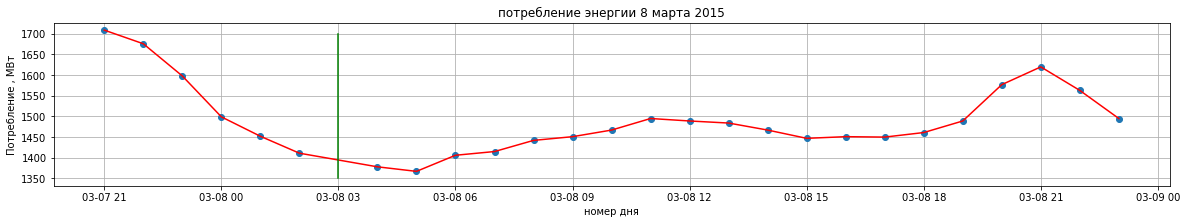

In [306]:
df = df.sort_index()

plt.figure(figsize=(20,3))
plt.plot(df['2015-03-07 21:00:00':'2015-03-8 23:00:00'].index,df['2015-03-07 21:00:00':'2015-03-08 23:00:00']['DUQ_MW'].values, 'o')
plt.plot(df['2015-03-07 21:00:00':'2015-03-8 23:00:00'].index,df['2015-03-07 21:00:00':'2015-03-08 23:00:00']['DUQ_MW'].values, 'r')
line_ = pd.to_datetime(pd.Series(['2015-03-08 03:00:00', '2015-03-08 03:00:00']))
plt.plot(line_,np.array([1350,1700]),'g')
plt.grid()
plt.xlabel('номер дня')
plt.ylabel('Потребление , МВт')
plt.title('потребление энергии 8 марта 2015')

plt.show()

##### Заполнение пропусков средними значениями между известными датами

In [307]:
lst = []
for data in range(len(missed_data)):
    lst.append(
        int(
            (df.loc[df['date']==missed_data[data]+1]['DUQ_MW'].values + 
            df.loc[df['date']==missed_data[data]-1]['DUQ_MW'].values)
            / 2))
lst = np.reshape(lst, (len(lst),1))

C:\Users\Nickel\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  """
C:\Users\Nickel\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  


In [308]:
df_data = pd.DataFrame(index = pd.to_datetime(pd.Series(missed_data)), columns =['DUQ_MW'] , data = lst)

In [309]:
df_data.tail()

,DUQ_MW
2013-11-03 02:00:00,1300
2014-03-09 03:00:00,1415
2015-03-08 03:00:00,1394
2016-03-13 03:00:00,1111
2017-03-12 03:00:00,1454


In [310]:
df = df.append(df_data,sort = False)
df['date'] = df.index
df.tail()

,DUQ_MW,date
2013-11-03 02:00:00,1300.0,2013-11-03 02:00:00
2014-03-09 03:00:00,1415.0,2014-03-09 03:00:00
2015-03-08 03:00:00,1394.0,2015-03-08 03:00:00
2016-03-13 03:00:00,1111.0,2016-03-13 03:00:00
2017-03-12 03:00:00,1454.0,2017-03-12 03:00:00


In [311]:
df = df.sort_index()

Заполнение пропусков проведено успешно

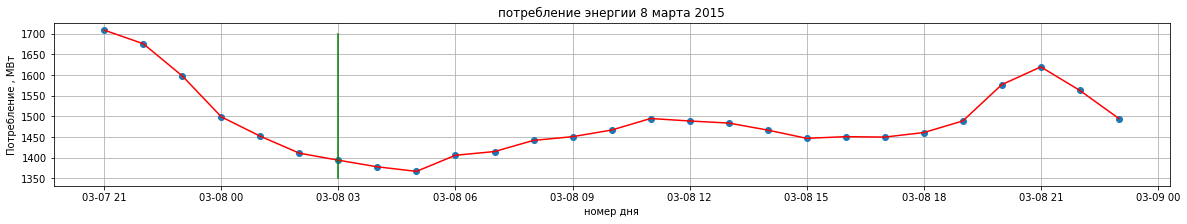

In [313]:
plt.figure(figsize=(20,3))
plt.plot(df['2015-03-07 21:00:00':'2015-03-8 23:00:00'].index,df['2015-03-07 21:00:00':'2015-03-08 23:00:00']['DUQ_MW'].values, 'o')
plt.plot(df['2015-03-07 21:00:00':'2015-03-8 23:00:00'].index,df['2015-03-07 21:00:00':'2015-03-08 23:00:00']['DUQ_MW'].values, 'r')
line_ = pd.to_datetime(pd.Series(['2015-03-08 03:00:00', '2015-03-08 03:00:00']))
plt.plot(line_,np.array([1350,1700]),'g')
plt.grid()
plt.xlabel('номер дня')
plt.ylabel('Потребление , МВт')
plt.title('потребление энергии 8 марта 2015')

plt.show()

Итог: в данных обнаружены дубляжи, которые, вероятно образовались в результате сезонного перевода часов в стране. Выявлен 21 пропуск во временном ряду. Пропуски были успешно заполнены соседними значениями.

С учетом указанных ошибок,  датасет достаточно хорошо подготовлен. Отчетливо видны сезонное увеличение потребления энергии в 06-09 месяцах, а также изменение нагрузки в течение недели. Датасет пригоден для построения прогнозов с высокой предсказательной способностью.

### <left>Ресемплинг данных (База Brent)<a class="anchor" id="res"></a><left>

In [314]:
brent_df = pd.read_excel('нефть-brent 2010-2019.xlsx', index_col=[0], parse_dates=[0])

In [315]:
brent_df.describe()

,Значение
count,2667.000000
mean,81.533547
std,26.349469
min,27.850000
25%,56.840000
50%,77.710000
75%,108.190000
max,126.900000


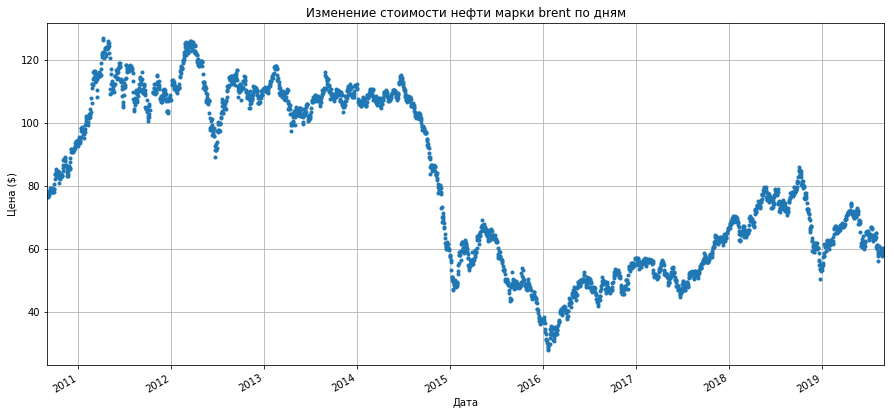

In [316]:
brent_df['Значение'].plot(style = '.', figsize = ( 15, 7 ), title = 'Изменение стоимости нефти марки brent по дням')
plt.ylabel('Цена ($)')
plt.grid()
plt.show()

In [317]:
brent_years_mean = brent_df.resample("Y").mean()
brent_months_mean = brent_df.resample("M").mean()
brent_weeks_mean = brent_df.resample("W").mean()

brent_years_std = brent_df.resample("Y").std()
brent_months_std = brent_df.resample("M").std()
brent_weeks_std = brent_df.resample("W").std()

### <left>График изменения среднего по выборке и среднего отклонения по выборке на недельных, месячных и годовых группах для Brent<a class="anchor" id="bgraph"></a><left>

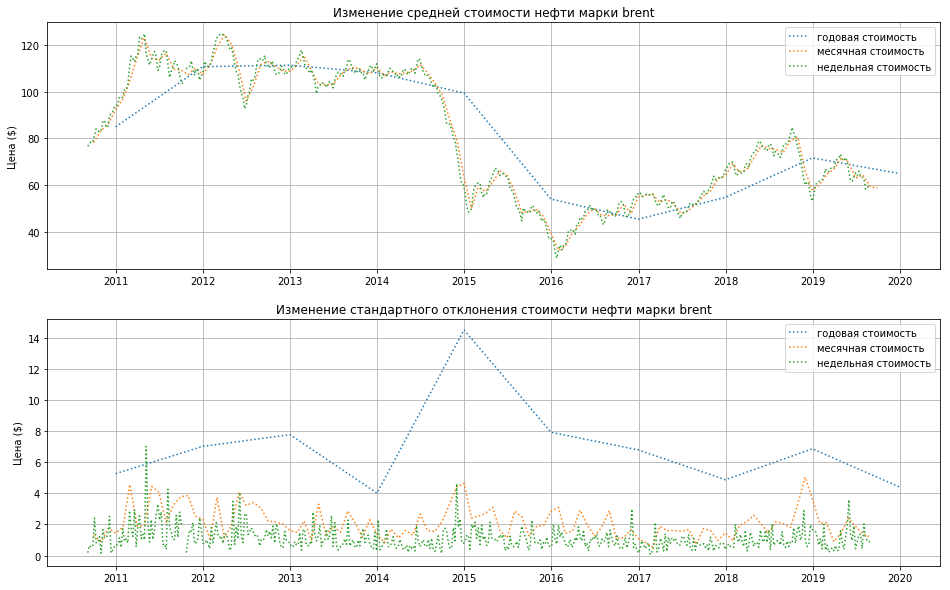

In [318]:
plt.figure(figsize=(16, 10))

plt.subplot(2,1,1)
plt.ylabel('Цена ($)')
plt.plot(brent_years_mean['Значение'], linestyle=':', label='годовая стоимость')
plt.plot(brent_months_mean['Значение'], linestyle=':', label='месячная стоимость')
plt.plot(brent_weeks_mean['Значение'], linestyle=':', label='недельная стоимость')
plt.title( 'Изменение средней стоимости нефти марки brent' )
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.ylabel('Цена ($)')
plt.plot(brent_years_std['Значение'], linestyle=':', label='годовая стоимость')
plt.plot(brent_months_std['Значение'], linestyle=':', label='месячная стоимость')
plt.plot(brent_weeks_std['Значение'], linestyle=':', label='недельная стоимость')
plt.title( 'Изменение стандартного отклонения стоимости нефти марки brent' )
plt.legend()
plt.grid()

plt.show()

На графиках видно, как усреднение значительно сглаживает локальные пиковые значения данных. Среднеквадратическое отклонение позволяет оценить, насколько значения из множества могут отличаться от среднего значения. Так, при обобщении ежедневных данных пропорционально растет погрешность достоверности данных.